# **Kaggle 2020 Suvery Analysis Using Clustering**

In this notebook, we will explore how a clustering approach can be used to analyze the results of the Kaggle 2020 Survey. The main highlights of the method are:

1. It is fully automated - requiring no manual manipulation of the data
2. The results are very visual - providing immediate insights into the data

The method is as follows:

1. Convert all the unique values in each column into numeric categorical values.
    This converts the dataframe into a numpy matrix.
2. Compute the cosine matrix of the dataframe. 
    Each row of the matrix (corresponding to each user) is now a vector. The cosine distance between      rows is a measure of how similar two users are.   
3. Cluster the rows using T distributed Stochastic Nearest Neighbor Embedding (TSNE). 
   This maps the clustered dataframe into two dimensions.
4. Color each row corresponding to the value of the column.

   This allows us to see how the responses to a question are distributed within the cluster map

Here is an example cluster image - this is for question 3 (country of origin). The image clusters neatly according to the country of origin. The steps towards the creation of this image are explained below. 

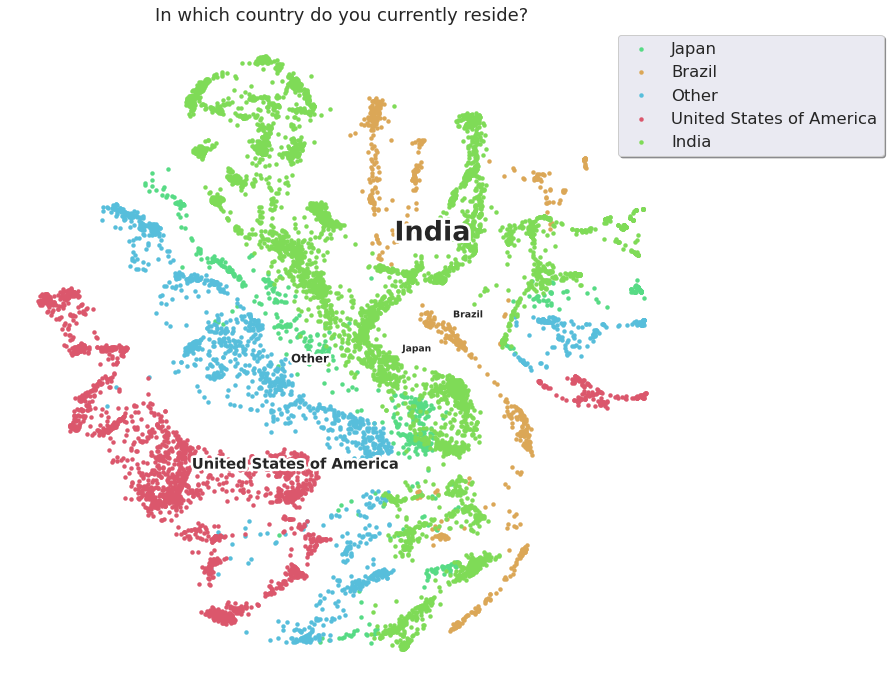

# Install Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import pairwise_distances
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import random
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Load the data

In [ ]:
survey = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

Let's take a look at what we are working with:

In [ ]:
survey.head()

We will collect all the questions into a dictionary, with the column as the key and the question as the value. 

Questions={column_name:survey_question}

In [ ]:
Questions=dict()
for q in survey.columns.tolist():
    Questions[q]=survey.loc[0,q]

We can now get rid of the first column and the first row. They are not useful for the clustering approach

In [ ]:
survey.drop('Time from Start to Finish (seconds)',axis=1,inplace=True)
survey.drop(0,axis=0,inplace=True)

> The next step is to collect the unique values in each column and rank them according to their istances. For example, in column 2, the labels are 'Man', 'Woman','Nonbinary' etc. The number of rows with each of these values is counted and stored in a dictionary. For the purpose of visualization we will also convert them into a value between 27 and 7 - which will serve as the fontsize for this label in our cluster plot 

In [ ]:
def label_generator(col):
    
    size_dict={}
    
    label_list=list(survey[col].unique())
    
    for label in label_list:
        size_dict[label]=len(survey[survey[col]==label])
        
    max_value=max(list(size_dict.values()))
    for label in label_list:
        size_dict[label]=np.around(size_dict[label]*20/max_value+7,2)
        
    sorted_dict={}
    for w in sorted(size_dict, key=size_dict.get, reverse=True):
        sorted_dict[w]=size_dict[w]
        
    return sorted_dict


In [ ]:
label_dict={}
columns=survey.columns.tolist()
for col in columns:
    label_dict[col]=label_generator(col)

The font sizes for the labels in column 2 are:

In [ ]:
label_dict['Q2']

#  **Vectorization**

Now we can convert the rows into categorical codes

In [ ]:
columns=survey.columns.tolist()
for col in columns:
    survey[col]=survey[col].astype('category')
    survey[col]=survey[col].cat.codes

Let's take a look at the dataframe again:

In [ ]:
survey.head()

Thus, each row of the original survey result has been converted to a vector.

# **Clustering**

We calculate first the pairwise distance matrix using the cosine distance. 

In [ ]:
print('Computing Cosine Matrix \n')
Matrix=survey.values
distance_matrix = pairwise_distances(Matrix, Matrix, metric='cosine', n_jobs=-1)

TSNE calculates the appropriate x and y position for each vectorized row such that similar rows (users with similar responses) cluster together. The overall shape of the plot can be changed by altering the random state. The value used here was found to be more aesthetically pleasing. This can take a little bit of time to run.

In [ ]:
print('TSNE \n')
state=77
tsne=TSNE(n_components=2,metric="precomputed",random_state=state,verbose=1,perplexity=40,n_iter=300)
tsne_results=tsne.fit_transform(distance_matrix)
survey['X']=tsne_results[:,0]
survey['Y']=tsne_results[:,1]
print('t-SNE done!')

The calculated x and y value are stored as columns 'X' and 'Y' in the survey dataframe. This will make our book keeping a lot easier.

Here is what the plot looks like:

In [ ]:
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(aspect='equal')

sc = ax.scatter(survey['X'],survey['Y'], lw=0, s=20,c='red')
ax.axis('off')
ax.axis('tight')

plt.show()

What we look for is if the plot has enough heterogenity to capture the entropy in our data. This one seems good enough. We will see further confirmation when we color each pixel according to it's column value.

# **Data Display and Analysis**

Before we can do that however, we would need to create a mapping between the labels in original survey frame and it's code. This will help in annotating our cluster images and in creating legends.

In [ ]:
new_label_dict={}
columns=survey.columns.tolist()
for col in columns:
    new_label_dict[col]=label_generator(col)

Finally, we are ready to create images corresponding to each column. 

The procedure is as follows:

1. Select a column.
2. Create a dictionary between the old and new column values (original values and their categorical   codes).
2. Plot each category separately in a different color.
3. Find the median position of the pixels corresponding to each category and affix the textual label at this position. 
4. The size of the label is proportional to the number of instances of that category. The larger label therefore is more common than a smaller label.
5. Plot the legend.
6. The title of the plot is the question corresponding to that particular column.

For the sake of clarity only the top 5 categories from each question (column) are displayed. 

All of this is encoded into the function below - which helps us reuse our code easily.

In [ ]:
def image_generator(col):
    
    encoder={}
    for i,label in enumerate(label_dict[col].keys()):
        encoder[label]=list(new_label_dict[col].keys())[i]
    
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    
    palette = np.array(sns.color_palette("hls", len(label_dict[col])))
    
    txts = []
    pixels=[]
    
    Labels=list(label_dict[col].keys())[::-1][-5:]
    
    for item in Labels:
        _survey=survey[survey[col]==encoder[item]]
        pixels.append(ax.scatter(_survey['X'],_survey['Y'], lw=0, s=20,c=palette[encoder[item].astype(np.int)]))
        if len(pixels)>4:
            break
            
    txts = []
    
    for item in Labels:
        # Position of each label.
        xtext, ytext = np.median(survey[survey[col]==encoder[item]][['X','Y']],axis=0)
        if not math.isnan(xtext) and not math.isnan(ytext):
            txt = ax.text(xtext, ytext, item, weight='bold',fontsize=label_dict[col][item])
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    plt.legend(pixels,Labels,bbox_to_anchor=(0.9, 1), loc='upper left', shadow=True)
    
    ax.axis('off')
    ax.axis('tight')
    plt.title(Questions[col])
    plt.show()

# **Survey Analysis - Results**

In [ ]:
image_generator('Q1')

The age group 25-29 is seen to the most common among the respondees, followed by the 22-24 age group (from the fontsize of the labels). 

In [ ]:
image_generator('Q2')

Men outnumber women by a huge margin. The red dots overwhelm the violet dots!

In [ ]:
image_generator('Q3')

This neat image shows the responses separating based on the country. The green India and the purple United States take the top two positions. One reason why the separation of clusters is so evident in this image could be that this column has the highest entropy (number of responses) - consequently, the clustering approach is incentivized to allot higher weight to this column over others

In [ ]:
image_generator('Q4')

In [ ]:
image_generator('Q5')

In [ ]:
image_generator('Q6')

In [ ]:
image_generator('Q7_Part_1')

Python is extensively used - as easily seen in the image

In [ ]:
image_generator('Q7_Part_3')

So is SQL

In [ ]:
image_generator('Q8')

In [ ]:
image_generator('Q11')

In [ ]:
image_generator('Q13')

A TPU has rarely been used by our community!

Similarly, each column can be converted into an image - which provides instant insight into the dataframe. I encourage you to try this out for yourself.

If you like this approach, please consider upvoting this notebook. 
Leave a comment and let me know what you think!

**Thank you for reading!**